# Import the data from xlsx 

In [41]:
import openpyxl
# Open the workbook and select the first worksheet
wb = openpyxl.load_workbook('wordle_data.xlsx')
sh = wb['Sheet1']

In [42]:
# List to hold dates
date_list = []
word_list = []
normal_people_list = []
hard_people_list = []
overall_percent_list = []

#Iterate through each row in worksheet and fetch values into dict
#value starts at row 3

for row in range(3, sh.max_row + 1):
    # Each row in the spreadsheet has data for one date
	date = sh.cell(row=row, column=2).value
	# if the date is none, then break the loop
	if date is None:
		break
	word = sh.cell(row=row, column=4).value
	normal_people = sh.cell(row=row, column=5).value
	hard_people = sh.cell(row=row, column=6).value
	# F to L as a list, then append the list to overall_percent_list
	daily_percent = [sh.cell(row=row, column=i).value for i in range(7, 14)]
	

	# Append the date and value to the appropriate list
	date_list.append(date)
	word_list.append(word)
	normal_people_list.append(normal_people)
	hard_people_list.append(hard_people)
	overall_percent_list.append(daily_percent)
 
# inverse all lists into chronological order
date_list.reverse()
word_list.reverse()
normal_people_list.reverse()
hard_people_list.reverse()
overall_percent_list.reverse()


# Data Preprocessing

In [43]:
import numpy as np

In [44]:
def moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')


(359,)
(359,)


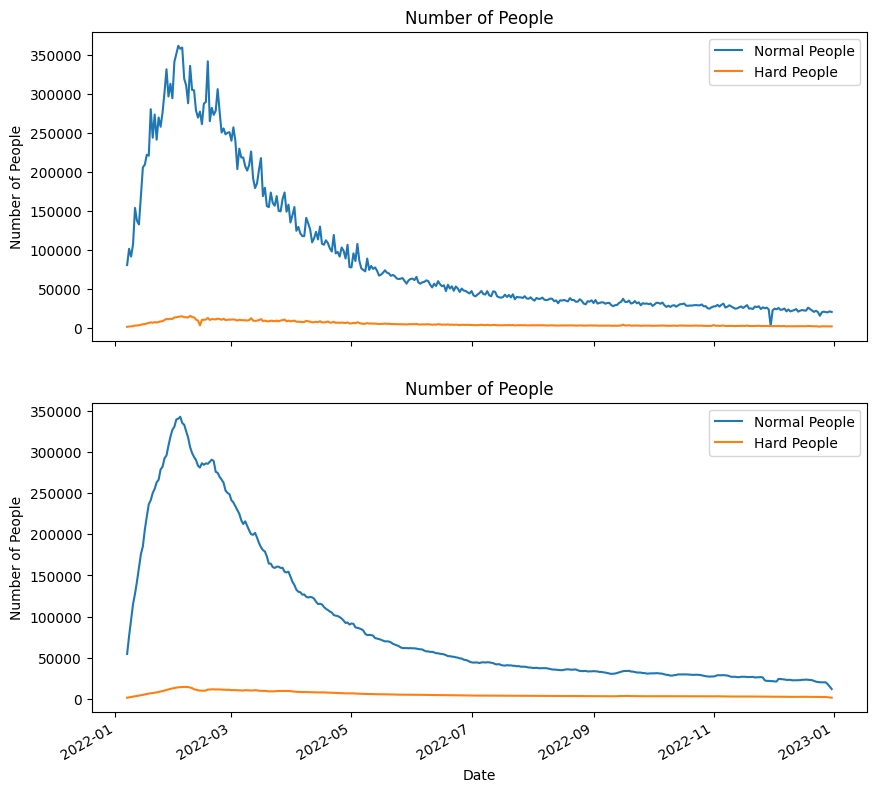

In [50]:
window_size = 7 # 7 days
smoothed_normal_people_list = moving_average(normal_people_list, window_size)
smoothed_hard_people_list = moving_average(hard_people_list, window_size)

# Plot the data for comparison in two graphs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot the data of normal people and hard people
ax1.plot(date_list, normal_people_list, label='Normal People')
ax1.plot(date_list, hard_people_list, label='Hard People')
ax1.set_title('Number of People')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of People')
ax1.legend()

# Plot the smoothed data of normal people and hard people
ax2.plot(date_list, smoothed_normal_people_list, label='Normal People')
ax2.plot(date_list, smoothed_hard_people_list, label='Hard People')
ax2.set_title('Number of People')
ax2.set_xlabel('Date')
ax2.set_ylabel('Number of People')
ax2.legend()


# Format the x-axis for dates (label formatting, rotation)
fig.autofmt_xdate()

# Show the plot
plt.show()



# Difficulty of words
1 try: 1 score

2 tries: 2 score

3 tries: 3 score

4 tries: 4 score

5 tries: 5 score

6 tries: 6 score

7 tries: 7 score

eg. $\frac{(1*a+2*b+3*c+4*d+5*c+6*e+7*f)}{100} = ~difficulty ~~coefficient$

In [46]:
# calculate the difficulty of each word
D_list = [] # key: word, value: difficulty

for i in range(len(word_list)):
	word = word_list[i]
	D_coefficient = (1 * overall_percent_list[i][0] + 2 * overall_percent_list[i][1] + 3 * overall_percent_list[i][2] + 4 * overall_percent_list[i][3] + 5 * overall_percent_list[i][4] + 6 * overall_percent_list[i][5] + 7 * overall_percent_list[i][6])/100
	D_list.append(D_coefficient)

# Random forest model
Predict number of participants

In [47]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [54]:
#Transfer the date into a float number list
date_list_float = []
for date in date_list:
	date_list_float.append(date.toordinal())

# Combine the input features: date, difficulty coeffient into an array
X = np.array([date_list_float, D_list]).T

# Use the normal people list as the target
y = np.array(smoothed_normal_people_list)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)


ValueError: Unknown label type: 'continuous'

In [30]:
from matplotlib import pyplot as plt

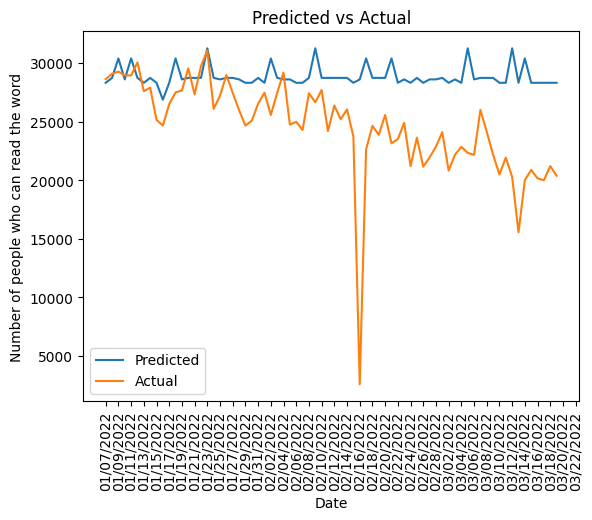

In [32]:
# Plot predict result for the testing set,
# X coordinates as the date with format MM/DD/YYYY
# Y coordinates as the number of people who can read the word

# Transfer the X corrdinates into a list of string
# Rotate X labels by 90 degrees, lessen the number of X labels to half
date_str_list = [date.strftime('%m/%d/%Y') for date in date_list]
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(date_str_list), 2), date_str_list[::2])


# plt.figure(figsize=(20, 10))

plt.plot(date_str_list[train_size:], y_pred, label='Predicted')
plt.plot(date_str_list[train_size:], y_test, label='Actual')
plt.xlabel('Date')
plt.ylabel('Number of people who can read the word')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()
